# <span style="color:blue">Walkthrough 4: Multi-objective evolution</span>

Dan Franks: daniel.franks@york.ac.uk

# <span style="color:blue">Learning Objectives</span>

1. Implement multi objective evolution
2. Impement individuals with non-standard structures (here a set)

# <span style="color:blue">The knapsack problem</span>

The knapsack problem is a multi-objective problem: Given a set of possible items, each with a weight and a value, maximize the value of items in the bag, while minimizing the weight. There is also a weight restriction and restriction on the number of items in the bag.

<img src="knapsack.png" alt="Knapsack" width = 400>

A fixed number of items can be put in the bag. So the objectives for the bag is:
1. Min(weight)
2. Max(bag_value)

With the constraints:
- weight < limit
- numItems < maxItems

## <span style="color:blue">Defining the problem</span>

In [1]:
import random
import numpy
import operator

In [2]:
NBR_ITEMS = 100     # The number of items to choose from
IND_INIT_SIZE = 5   # The initial number of random items in a bag for a new individual
MAX_ITEM = 50       # Max items that can be in the bag
MAX_WEIGHT = 50     # Max weight of the bag

The below creates a dictionary of random items that can be added to the knapsack. Item name is an integer, and value is a (weight, value) tuple.

In [3]:
NBR_ITEMS

items = {}
for i in range(NBR_ITEMS):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))

In [4]:
items

{0: (5, 2.67983816695051),
 1: (7, 50.57527640680139),
 2: (8, 85.45641090539196),
 3: (9, 58.844848280709726),
 4: (10, 72.15982009552486),
 5: (1, 15.130576044760847),
 6: (9, 4.726715104880885),
 7: (10, 5.939723629876747),
 8: (8, 11.639910230367423),
 9: (8, 47.323436273947095),
 10: (4, 71.2565026937531),
 11: (8, 75.56709484659613),
 12: (6, 12.282497443013918),
 13: (5, 98.9172481978659),
 14: (2, 31.96160677024683),
 15: (5, 9.129013415111976),
 16: (5, 51.10766792168611),
 17: (8, 20.459210014992358),
 18: (10, 1.9882767703529813),
 19: (7, 94.68428812911704),
 20: (2, 27.063653382759135),
 21: (1, 39.774732677368384),
 22: (6, 72.21107959419783),
 23: (9, 72.54877860419255),
 24: (7, 48.375392988576195),
 25: (7, 8.843950168627224),
 26: (7, 0.8552645566727746),
 27: (4, 91.44008695221478),
 28: (9, 68.17639411393166),
 29: (4, 10.555641865100462),
 30: (6, 4.382931659033639),
 31: (3, 59.425901658237),
 32: (8, 54.88590246485219),
 33: (8, 64.8624337848109),
 34: (9, 25.592

## <span style="color:blue">The GA</span>

In [5]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

Many evolutionary algorithm textbooks mention that the best way to have an efficient algorithm is to have a representation close the problem. **Thus, we let our individuals inherit from the set class.**

In [6]:
creator.create("Fitness", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", set, fitness=creator.Fitness)

Set up your toolbox below by adding attr_item and individual.

In [7]:
toolbox = base.Toolbox()
toolbox.register("attr_item", random.randrange, NBR_ITEMS)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_item, IND_INIT_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Next define your evaluation function.  

Remember that now we need to return two fitness items (weight and value). To ensure overweighted bags are always dominated, set the weight high (10000) and the value to zero for those that violate the constrains.

In [8]:
def evalKnapsack(individual):
    weight = 0.0
    value = 0.0
    for item in individual:
        weight += items[item][0]
        value += items[item][1]
    if len(individual) > MAX_ITEM or weight > MAX_WEIGHT:
        return 10000, 0
    return weight, value

The crossover and mutation operators in DEAP cannot be applied directly on sets. So you need to define your own.

We produce two children where the first child is the intersection of the two parent sets and the second child their absolute difference.

In [9]:
def cxSet(ind1, ind2):
    temp = set(ind1)                # Used in order to keep type
    ind1 &= ind2                    # Intersection (inplace)
    ind2 ^= temp                    # Abslute difference (inplace)
    return ind1, ind2

Items in sets cannot be changed, but you can remove or add elements. Thus, mutation pops or adds elements to the set (i.e. adds or removes an item from the bag).

In [10]:
def mutSet(individual):
    if random.random() < 0.5:
        if len(individual) > 0:
            individual.remove(random.choice(sorted(tuple(individual))))
    else:
        individual.add(random.randrange(NBR_ITEMS))
    return individual,

In [11]:
toolbox.register("evaluate", evalKnapsack)
toolbox.register("mate", cxSet)
toolbox.register("mutate", mutSet)

We have registered our functions in the toolbox. For select we use tools.selNSGA2, to use the NSGA2 algorithm. You can also use SEPA2 in DEAP, but it is extremely slow.

In [12]:
toolbox.register("select", tools.selNSGA2)
#toolbox.register("select", tools.selSPEA2)

In [13]:
inv1 = toolbox.individual()

In [14]:
print(inv1)

Individual({58, 35, 13, 39})


In [15]:
NGEN = 500
popSize = MU = 200
LAMBDA = 400
CXPB = 0.5
MUTPB = 0.2

I next define a function for comparing whether two solutions are equal. The numpy.close function can also be given a tolerence, which you could increase.

It is important to note that this function should typically work on the solution, rather than fitness. This is because we want variation in the solutions along the front, and different solutions might have similar fitnesses for more complex problems. However, here we variable solution lengths and this can be done on the fitness, which is likely to lead to similar results here.

It would be possible to write your own function here that only returns true if the solution is the same length, and if they are then sorting and comparing the solutions. You can have a go at writing this in the workshop if you finish the workshop mateiral.

In [25]:
def pareto_eq(ind1, ind2):
    return numpy.allclose(ind1.fitness.values, ind2.fitness.values)

In [28]:
pop = toolbox.population(n=popSize)
hof = tools.ParetoFront(similar=pareto_eq)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean, axis=0)
stats.register("std", numpy.std, axis=0)
stats.register("min", numpy.min, axis=0)
stats.register("max", numpy.max, axis=0)

Below, we use a built-in algorithm for brevity. Here, we use the Mu + Lambda algorithm. This just allows us to specify two more parameters. Lambda is the number of individuals to reproduce into the next generation (we just set it to a constant population size) and Mu is the number of children to produce in each generation. We set this to double the population size so that we have choice when it comes to selection.

In [29]:
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)

gen	nevals	avg                        	std                      	min                      	max                        
0  	200   	[ 26.27       240.37055575]	[ 5.87172036 65.53918522]	[10.         44.39775106]	[ 40.         388.66912787]
1  	283   	[ 4.315      66.26470189]  	[  8.44605085 122.77410103]	[0. 0.]                  	[ 34.         414.44749536]
2  	276   	[ 2.9        46.37725305]  	[  7.43706932 112.64274858]	[0. 0.]                  	[ 40.         466.68475173]
3  	285   	[ 3.65       57.76882306]  	[  8.81915529 128.14281114]	[0. 0.]                  	[ 45.         525.70791158]
4  	278   	[ 4.155      68.19224958]  	[  9.00727345 137.3464814 ]	[0. 0.]                  	[ 37.         528.86608176]
5  	272   	[ 2.285      46.61351309]  	[  6.28520286 111.9504026 ]	[0. 0.]                  	[ 37.         528.86608176]
6  	272   	[ 2.69       52.83242192]  	[  7.11504743 122.11028144]	[0. 0.]                  	[ 37.         528.86608176]
7  	280   	[ 4.325      83.91849136]

67 	290   	[ 21.835      583.97513611]	[ 20.28910483 484.29424203]	[0. 0.]                  	[  50.         1194.55716477]
68 	293   	[ 30.5        797.67348747]	[ 19.10078532 423.7212946 ]	[0. 0.]                  	[  50.         1194.55716477]
69 	281   	[ 32.975     873.6079361]  	[ 16.62511278 334.19978928]	[0. 0.]                  	[  50.         1194.55716477]
70 	272   	[ 35.95       926.18722184]	[ 17.20574032 344.36864321]	[0. 0.]                  	[  50.         1194.55716477]
71 	287   	[ 35.56       919.86795856]	[ 17.70074575 355.05349695]	[0. 0.]                  	[  50.         1194.55716477]
72 	281   	[ 36.18       943.54793079]	[ 16.08283557 311.47587137]	[0. 0.]                  	[  50.         1194.55716477]
73 	265   	[ 37.19       960.26425456]	[ 15.98792982 312.34579975]	[0. 0.]                  	[  50.         1194.55716477]
74 	287   	[ 33.21       888.00578015]	[ 16.354079   327.20782932]	[0. 0.]                  	[  50.         1194.55716477]
75 	287   	[ 30.

131	289   	[  50.         1194.55716477]	[0.00000000e+00 3.41060513e-12]	[  50.         1194.55716477]	[  50.         1194.55716477]
132	274   	[  49.84       1191.86829808]	[ 0.81510735 13.38282006]      	[  44.         1105.92016749]	[  50.         1194.55716477]
133	281   	[  49.725      1189.98469475]	[ 1.24071552 20.52099269]      	[  40.         1020.63948901]	[  50.         1194.55716477]
134	278   	[  49.66       1188.94928537]	[ 1.40868733 23.10401967]      	[  40.         1020.63948901]	[  50.         1194.55716477]
135	282   	[  49.545      1187.04693171]	[ 1.79665662 29.7148454 ]      	[ 37.         965.71286026]  	[  50.         1194.55716477]
136	268   	[  49.66       1188.97944167]	[ 1.66565303 27.09960457]      	[ 36.         966.13448745]  	[  50.         1194.55716477]
137	281   	[  50.         1194.55716477]	[0.00000000e+00 3.41060513e-12]	[  50.         1194.55716477]	[  50.         1194.55716477]
138	279   	[  49.88       1192.59091204]	[ 0.75206383 11.96388321]   

197	271   	[ 34.655      958.95397428]  	[ 11.67972495 213.60341042]    	[  7.         326.42309448]  	[  50.         1205.20038879]
198	269   	[ 34.58       955.52217099]  	[ 12.98551501 238.9971209 ]    	[  7.         326.42309448]  	[  50.         1205.20038879]
199	290   	[  39.405      1032.13375285]	[ 12.85772044 236.79571308]    	[  6.         272.36113702]  	[  50.         1205.20038879]
200	283   	[  38.55       1016.11767042]	[ 12.84552451 243.62782046]    	[  6.         272.36113702]  	[  50.         1205.20038879]
201	272   	[ 36.42       981.35822468]  	[ 12.88346227 255.7502291 ]    	[  4.        206.5826914]    	[  50.         1205.20038879]
202	283   	[ 30.305      871.68568063]  	[ 13.08594571 282.12703944]    	[  4.         208.56358104]  	[  49.         1222.70558609]
203	280   	[ 31.51       895.07552852]  	[ 12.58013911 275.7695074 ]    	[  4.         208.56358104]  	[  49.         1222.70558609]
204	257   	[ 33.57       946.39247705]  	[ 10.56480478 215.21878184] 

260	269   	[  49.74       1241.91132636]	[ 1.17575508 19.19360709]      	[  40.         1086.61694561]	[  50.         1246.24997746]
261	281   	[  49.625      1239.84328707]	[ 1.43330911 24.13900098]      	[  40.         1086.61694561]	[  50.         1246.24997746]
262	288   	[  48.385      1218.58108875]	[ 2.68268056 46.02162727]      	[  38.         1012.28660117]	[  50.         1250.45881124]
263	282   	[  45.435      1169.52650852]	[ 2.56042477 39.86957128]      	[  36.         1000.17513955]	[  50.         1250.45881124]
264	276   	[  43.815      1142.97729476]	[ 4.24037439 66.54301953]      	[ 32.         946.83126557]  	[  50.         1250.45881124]
265	269   	[  43.28       1133.32342506]	[ 5.32837686 86.08320752]      	[ 32.         946.83126557]  	[  50.         1250.45881124]
266	274   	[  39.035      1063.26424039]	[ 5.90201449 97.09040326]      	[ 30.         903.23967972]  	[  50.         1250.45881124]
267	292   	[  36.96       1028.49336674]	[  6.89843461 114.03511407] 

327	273   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
328	286   	[  49.91       1249.29233622]	[0.57610763 9.55085642]        	[  45.         1173.52632562]	[  50.         1250.82254426]
329	264   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
330	290   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
331	286   	[  49.93       1249.58817846]	[0.50507425 8.71224327]        	[  45.         1165.96349298]	[  50.         1250.82254426]
332	277   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
333	288   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
334	283   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-

393	266   	[  49.915      1249.35135948]	[0.54568764 9.17689294]        	[  45.         1173.52632562]	[  50.         1250.82254426]
394	283   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
395	268   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
396	277   	[  49.9       1248.8460204]  	[ 0.60827625 11.34551939]      	[  45.         1165.96349298]	[  50.         1250.82254426]
397	284   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
398	268   	[  49.91       1249.29853479]	[0.58472216 9.5742024 ]        	[  45.         1173.52632562]	[  50.         1250.82254426]
399	268   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
400	274   	[  49.87       1248.63122199]	[ 0.70221079 11.5635938 ]   

458	270   	[  49.855      1248.35658884]	[ 0.82702781 13.78327024]      	[  42.         1118.59969687]	[  50.         1250.82254426]
459	286   	[  49.825      1247.86921725]	[ 0.89686956 14.80697943]      	[  42.         1118.59969687]	[  50.         1250.82254426]
460	271   	[  49.705      1245.90375651]	[ 1.36307557 22.3588888 ]      	[  40.         1088.66727434]	[  50.         1250.82254426]
461	283   	[  49.475      1242.10509099]	[ 1.99483709 32.89602919]      	[  37.         1033.74064558]	[  50.         1250.82254426]
462	281   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-12]	[  50.         1250.82254426]	[  50.         1250.82254426]
463	275   	[  49.89       1248.96487839]	[ 0.64645185 10.62084522]      	[  45.         1173.52632562]	[  50.         1250.82254426]
464	281   	[  49.88       1248.81306366]	[ 0.66       10.80855243]      	[  45.         1173.52632562]	[  50.         1250.82254426]
465	267   	[  50.         1250.82254426]	[0.00000000e+00 2.50111043e-

import matplotlib.pyplot as plt
%matplotlib inline

gen = log.select("gen")
avgs = log.select("avg")
stds = log.select("std")

In [32]:
avgs_weight = [item[0] for item in avgs]
avgs_value = [item[1] for item in avgs]

In [33]:
avgs

[array([ 26.27      , 240.37055575]),
 array([ 4.315     , 66.26470189]),
 array([ 2.9       , 46.37725305]),
 array([ 3.65      , 57.76882306]),
 array([ 4.155     , 68.19224958]),
 array([ 2.285     , 46.61351309]),
 array([ 2.69      , 52.83242192]),
 array([ 4.325     , 83.91849136]),
 array([ 3.92      , 67.60711416]),
 array([ 3.725     , 68.03491339]),
 array([ 5.385     , 93.25164646]),
 array([ 3.975     , 83.01688131]),
 array([ 2.835    , 59.8708585]),
 array([ 1.89      , 48.49652817]),
 array([ 3.34      , 82.30976667]),
 array([  5.285     , 125.16223908]),
 array([  5.515     , 124.47367381]),
 array([  5.235     , 134.55567697]),
 array([  6.62      , 166.75254306]),
 array([  9.895     , 250.41786929]),
 array([  3.965     , 107.73060068]),
 array([  5.81      , 158.98365565]),
 array([  8.655     , 230.05193351]),
 array([  9.805     , 265.50880892]),
 array([  3.335     , 128.29536229]),
 array([  4.39      , 151.46051386]),
 array([  5.05      , 167.24172496]),
 arr

Text(0, 0.5, 'Fitness (weight)')

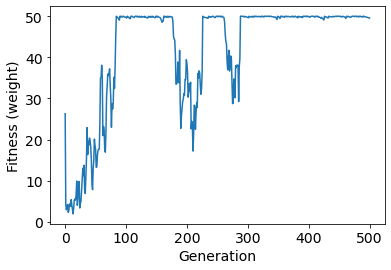

In [34]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs_weight)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness (weight)")

Text(0, 0.5, 'Fitness (value)')

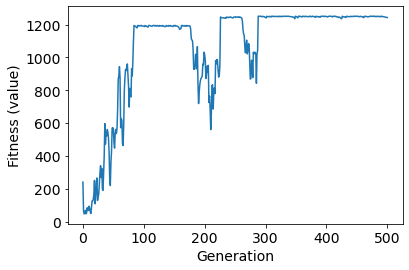

In [35]:
fig2, ax2 = plt.subplots()
line2 = ax2.plot(gen, avgs_value)
ax2.set_xlabel("Generation")
ax2.set_ylabel("Fitness (value)")

Normally we would now plot the Pareto front. But here we have solutions that have anything from 0 upwards of solution dimensions (i.e. what is in the bag). So we can't plot the solution space very easily. You will, however, be doing this in the workshop.